In [3]:
import json
import sys
import os
import matplotlib.pyplot as plt 
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))
import nest_asyncio
nest_asyncio.apply()
import asyncio
import json
import pubmetric.network as nw
from scipy.stats import ttest_rel
import numpy as np 
from pubmetric import pckg_dev as dev

In [4]:
path_to_data = '../out_20240801231111' 
loaded_graph = asyncio.run(nw.create_citation_network(inpath=path_to_data, load_graph=True))

2024-08-06 16:45:37 - Graph loaded from ../out_20240801231111


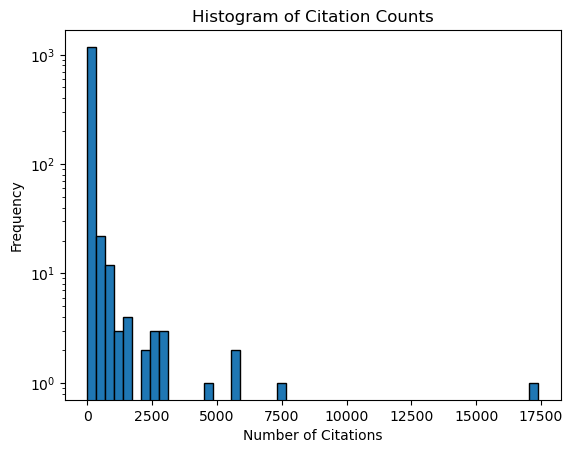

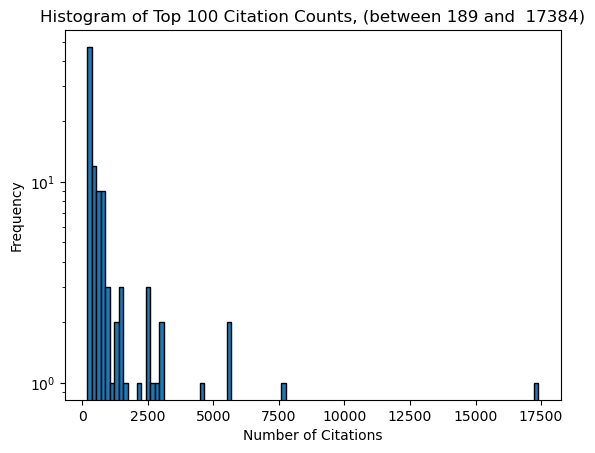

In [5]:
# citation counts for each tool
citation_counts = {tool['name']: tool['nr_citations'] for tool in loaded_graph.vs}
citation_values = list(citation_counts.values())

# TODO subfiugures
# all citation counts
plt.hist(citation_values, bins=50, edgecolor='black')
plt.xlabel('Number of Citations')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Histogram of Citation Counts')
plt.show()

# Sorting citations in descending order to get the top 100 most cited tools
sorted_citation_counts = dict(sorted(citation_counts.items(), key=lambda item: item[1], reverse=True))
top_citation_counts = list(sorted_citation_counts.values())[0:100]

# Plotting histogram of the top 100 citation counts
plt.hist(top_citation_counts, bins=100, edgecolor='black')
plt.xlabel('Number of Citations')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title(f'Histogram of Top 100 Citation Counts, (between {min(top_citation_counts)} and  {max(top_citation_counts)})')
plt.show()

# Loading a graph to analyse the distribution of edge weights


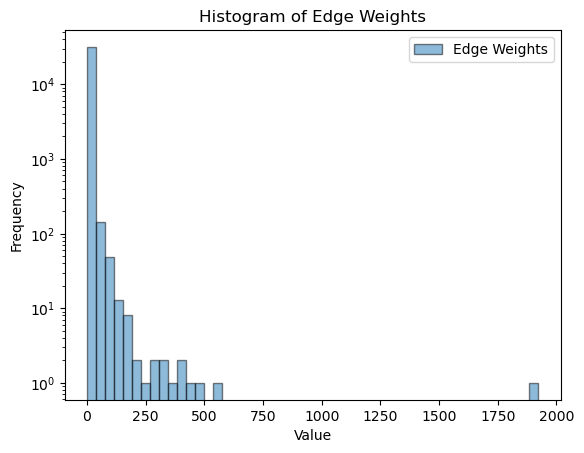

In [7]:
edge_weights = loaded_graph.es['weight']

plt.hist(edge_weights, bins=50, alpha=0.5, label='Edge Weights', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Histogram of Edge Weights')
plt.legend(loc='upper right')
plt.show()



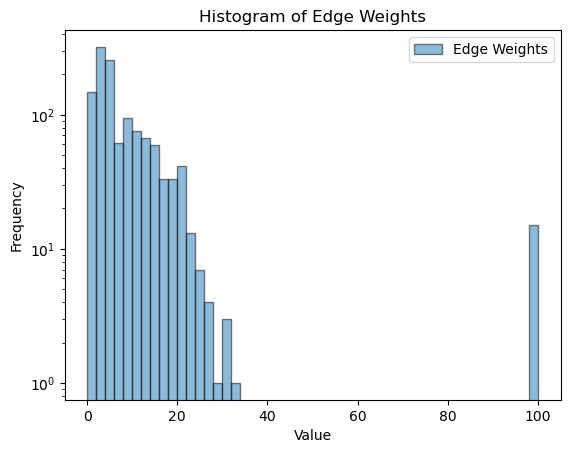

In [20]:
ages = loaded_graph.vs['age']

plt.hist(ages, bins=50, alpha=0.5, label='Edge Weights', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Histogram of Edge Weights')
plt.legend(loc='upper right')
plt.show()

#TODO: here is where we get the 

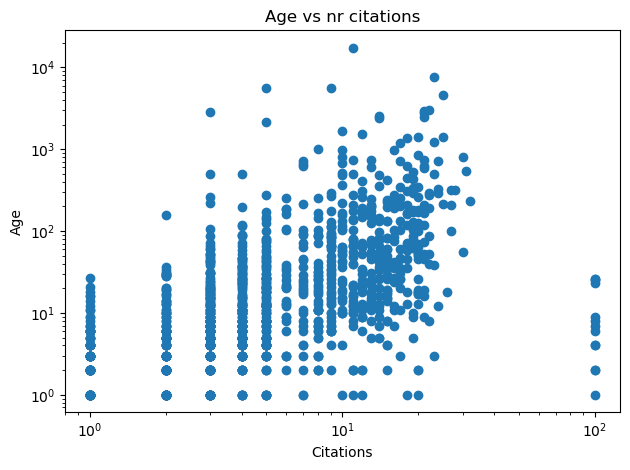

In [21]:
citations = loaded_graph.vs['nr_citations']

plt.scatter(ages, citations)
plt.title('Age vs nr citations')
plt.xlabel('Citations')
plt.ylabel('Age')
plt.yscale('log')
plt.xscale('log')
plt.tight_layout()
plt.show()


/tmp/ipykernel_60768/1920837738.py:13: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='age_bins', y='citations', data=data, scale='width')


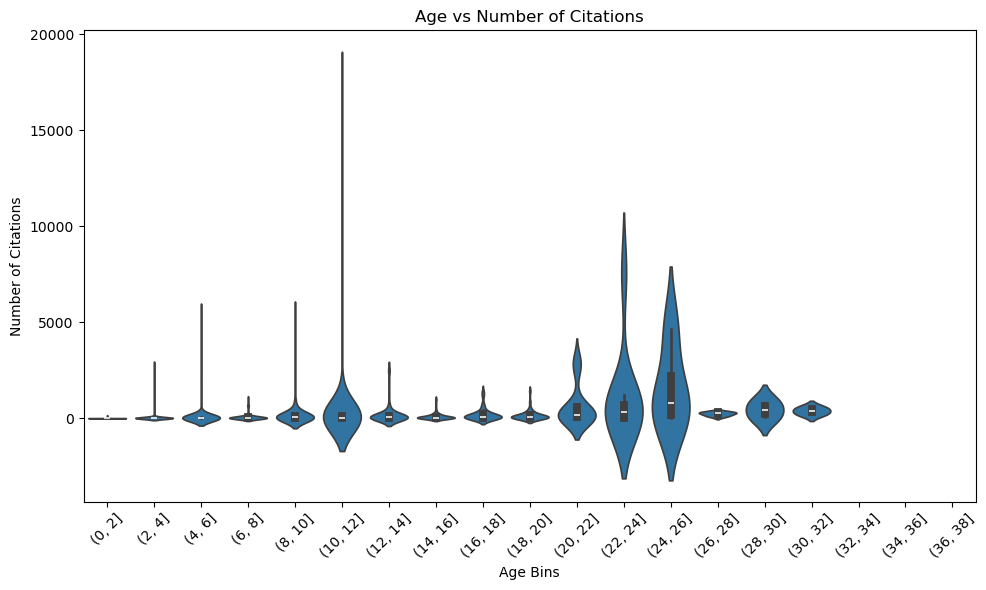

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Create a DataFrame for easier manipulation
data = pd.DataFrame({'ages': ages, 'citations': citations})

bins = np.arange(0, 40, 2)
data['age_bins'] = pd.cut(data['ages'], bins)

plt.figure(figsize=(10, 6))
sns.violinplot(x='age_bins', y='citations', data=data, scale='width')

plt.title('Age vs Number of Citations')
plt.xlabel('Age Bins')
plt.ylabel('Number of Citations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# why is it below 0??